In [11]:
## what do i need? i need the temp, the radius (from the model) and i need the distance.
## the temp i can get from the luminosity and the radius and the velocity
## i am left with the distance ok got the distance good
from astropy import units as u
from astropy import constants as const
import astropy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

distance = 26.4 * 10**6 * u.pc

R_e = {3/2: 3.07 * 10**12 * u.cm, 3: 4.57 * 10**12 * u.cm}

v_e = {3/2: 2.47 * 10**9 * u.cm / u.s, 3: 2.69 * 10**9 * u.cm / u.s}

M_e = {3/2: 3.99 * 10**-2 * u.solMass, 3: 38.34 * 10**-2 * u.solMass}




In [55]:

## we set M_c = M_sun becuase the dependence is very week
M_c = 1 * u.solMass

## M = Me + Mc
M = lambda n: M_e[n] + M_c

## vs,8.5 is the velocity of the shock vs in units of 10^8.5 cm s−1
v = lambda n: v_e[n] / (10**8.5)

## where R13 = Re/10^13 cm
R_13 = lambda n: R_e[n] / (10**13)

## where k0.34 is the opacity in units of 0.34 cm2 g−1
## where k0.34 is the opacity in units of 0.34 cm2 g−1
## k = 1 * 0.34 * u.cm**2 / u.g
k = 1

def f_p(n):
    """
    returns the ratio between the enitial mass and the core mass.
    """
    if n == 3/2:
        return (M_e[n]/M_c)**0.5
    elif n == 3:
        return 0.08 * (M_e[n]/M_c)
    

    


In [56]:
const.sigma_sb.to(u.erg * u.cm**-2 * u.s**-1 * u.K**-4)

<Quantity 5.67037442e-05 erg / (cm2 K4 s)>

In [57]:
def T(n, t):
    """
    the color temp is given by this function.
    where t is in days and M is in solar masses.
    """
    if n == 3/2:
        nums = [2.05, 0.027]
    else:
        nums = [1.96, 0.016]
    T = (nums[0] * 10**4 *(((v(n) * t)**2) / (f_p(n) * M(n) * k))**nums[1] * (R_13(n) / k)**0.25 * t**-0.5).value
    return T * u.K

def L(n, t):
    """
    the final luminosity function as SW16, t in days
    """
    if n == 3/2:
        nums = [1.88, -0.086, 1.67, 0.8]
    else:
        nums = [1.66, -0.175, 4.57, 0.73]
    first = nums[0] * 10**42
    second = ((v(n) * t**2)/(f_p(n) * M(n) * k))**nums[1]
    third = (v(n)**2 * R_13(n)) / k
    fourth = np.exp(-(((nums[2] * t) / (19.5 * k * M_e[n] * v(n)**-1)**0.5)**nums[3]).value)
    return first * second.value * third.value * fourth * u.erg / u.s


def R_in_rsun(n, t):
    """
    gets t in days, then converts the result to rsun
    R^2 = sqrt(L(t)/4pi sigma T^4)
    """
    sigma_sb = const.sigma_sb.to(u.erg * u.cm**-2 * u.s**-1 * u.K**-4)
    return np.sqrt(L(n,t) / (4 * np.pi * sigma_sb * T(n, t)**4)).to(u.solRad)
    


In [66]:
import pysynphot as S
import os

def get_Mag(n, t):
    bb = S.BlackBody(T(n, t).value)
    
    bp = S.ObsBandpass('v')
    
    obs = S.Observation(bb, bp)
   

    return obs.effstim('VegaMag') - 2.5*np.log10(((R_in_rsun(n, t) / (1 * u.solRad))**2)*((1000.0 * u.pc/distance)**2))
    
    


(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The wavese

(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The wavese

(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The wavese

(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The wavese

(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(C:\ProgramData\Anaconda3\Lib\site-packages\pysynphot\important data\comp\nonhst\johnson_v_004_syn.fits) does not have a defined binset in the wavecat table. The wavese

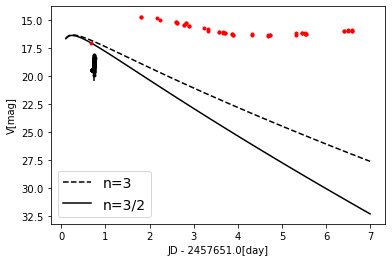

In [69]:
our_path = r"C:\Users\User\OneDrive - mail.tau.ac.il\Desktop\אוניברסיטה\אסטרו נודר\פרויקט קיץ\התחלה של קוד\astro_summer_project\starting with data\excel files\our_data.xlsx"
their_path = r"C:\Users\User\OneDrive - mail.tau.ac.il\Desktop\אוניברסיטה\אסטרו נודר\פרויקט קיץ\התחלה של קוד\astro_summer_project\starting with data\excel files\their_data.xlsx"


our_data = pd.read_excel(our_path, sheet_name='the graph data')

their_data = pd.read_excel(their_path, sheet_name='the graph data')

x_their = their_data.loc[:, 'JD - 2457651.0[day]']
y_their = their_data.loc[:, 'V[mag]']
yerr_their = their_data.loc[:, 'error_V[mag]']

x_our = our_data.loc[:, 'JD - 2457651.0[day]']
y_our = our_data.loc[:, 'V[mag]']
yerr_our = our_data.loc[:, 'error_V[mag]']

plt.errorbar(x_their, y_their, yerr_their, fmt='.k', capsize=0)
plt.errorbar(x_our, y_our, yerr_our, fmt='.r')


time_line = np.linspace(0.1, 7, 100) * u.d
n = 3
plt.plot(time_line, np.array([get_Mag(n, time) for time in time_line]), '--k', label='n=3')

n = 3/2
plt.plot(time_line, np.array([get_Mag(n, time) for time in time_line]), 'k', label='n=3/2')


plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.legend(fontsize=14)
plt.show();